Usaremos el mismo modelo que en Greedy y cambiamos Greedy por Boltzmann

In [99]:
# Crear memoria
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Política Boltzmann
policy = BoltzmannQPolicy(tau=2.0)

# Crear agente DDQN
boltzmann_ddqn = DQNAgent(
    model=best_params_model,  # Modelo de la red neuronal
    nb_actions=nb_actions,  # Número de acciones posibles
    policy=policy,  # Política de exploración Boltzmann
    memory=memory,  # Replay buffer
    nb_steps_warmup=steps_warmup,  # Pasos iniciales sin actualizar la red
    gamma=gamma,  # Factor de descuento
    target_model_update=target_model_update,  # Frecuencia de actualización de la red objetivo
    train_interval=train_interval,  # Intervalo de entrenamiento
    batch_size=batch_size,  # Tamaño del batch
    enable_double_dqn=True  # Habilitar Double DQN
)

# Archivos para guardar el modelo
model_name = 'Boltzmann_DDQN_'
best_filename = f'best_{model_name}{env_name}_weights.h5f'
log_filename = f'{model_name}{env_name}_log.json'
final_filename = f'{model_name}{env_name}_weights.h5f'

# Callback para guardar el mejor modelo
best_model_saver = BestModelSaver(
    filepath=best_filename,
    monitor='episode_reward',
    mode='max'
)

# Callback para decaimiento de tau
class TauDecayCallback(Callback):
    def __init__(self, policy, tau_start=2.0, tau_min=0.15, decay_rate=0.9999):
        super(TauDecayCallback, self).__init__()
        self.policy = policy
        self.tau = tau_start
        self.tau_min = tau_min
        self.decay_rate = decay_rate

    def on_step_end(self, step, logs={}):
        self.tau = max(self.tau * self.decay_rate, self.tau_min)
        self.policy.tau = self.tau  # Actualizar tau en la política

    def on_episode_end(self, episode, logs={}):
        print(f"Episode {episode}: tau = {self.tau:.4f}")

# Crear callback para ajustar tau dinámicamente
tau_decay_callback = TauDecayCallback(policy=policy, tau_start=2.0, tau_min=0.15, decay_rate=0.9999)

# Configurar callbacks
callbacks = [FileLogger(log_filename, interval=100), best_model_saver, tau_decay_callback]

# Compilar el modelo
boltzmann_ddqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenar
boltzmann_ddqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

Training for 50000 steps ...


C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Episode 0: episode_reward improved from -inf to -253.0000. Saving weights.
Episode 0: tau = 1.9498
   254/50000: episode: 1, duration: 6.551s, episode steps: 254, steps per second:  39, episode reward: -253.000, mean reward: -0.996 [-1.000,  0.000], mean action: 0.945 [0.000, 2.000],  loss: --, mae: --, mean_q: --


C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: tau = 1.8971
   528/50000: episode: 2, duration: 17.486s, episode steps: 274, steps per second:  16, episode reward: -273.000, mean reward: -0.996 [-1.000,  0.000], mean action: 0.945 [0.000, 2.000],  loss: 0.517188, mae: 25.340507, mean_q: -37.043481
Episode 2: tau = 1.8337
   868/50000: episode: 3, duration: 5.789s, episode steps: 340, steps per second:  59, episode reward: -339.000, mean reward: -0.997 [-1.000,  0.000], mean action: 1.021 [0.000, 2.000],  loss: 0.215446, mae: 26.212432, mean_q: -38.560386

Episode 3: episode_reward improved from -253.0000 to -237.0000. Saving weights.
Episode 3: tau = 1.7906
  1106/50000: episode: 4, duration: 5.560s, episode steps: 238, steps per second:  43, episode reward: -237.000, mean reward: -0.996 [-1.000,  0.000], mean action: 0.983 [0.000, 2.000],  loss: 0.289303, mae: 27.080204, mean_q: -39.822340

Episode 4: episode_reward improved from -237.0000 to -210.0000. Saving weights.
Episode 4: tau = 1.7532
  1317/50000: episode: 5, d

In [102]:
# Salvar pesos finales
final_filename = f'{model_name}{env_name}_weights.h5f'
boltzmann_ddqn.save_weights(final_filename, overwrite=True)

# Testear
boltzmann_ddqn.load_weights(best_filename)
boltzmann_ddqn.test(env, nb_episodes=20, visualize=False)

Testing for 20 episodes ...
Episode 1: reward: -88.000, steps: 89
Episode 2: reward: -75.000, steps: 76
Episode 3: reward: -76.000, steps: 77
Episode 4: reward: -74.000, steps: 75
Episode 5: reward: -69.000, steps: 70
Episode 6: reward: -90.000, steps: 91
Episode 7: reward: -76.000, steps: 77
Episode 8: reward: -84.000, steps: 85
Episode 9: reward: -88.000, steps: 89
Episode 10: reward: -75.000, steps: 76
Episode 11: reward: -89.000, steps: 90
Episode 12: reward: -75.000, steps: 76
Episode 13: reward: -102.000, steps: 103
Episode 14: reward: -88.000, steps: 89
Episode 15: reward: -68.000, steps: 69
Episode 16: reward: -75.000, steps: 76
Episode 17: reward: -76.000, steps: 77
Episode 18: reward: -138.000, steps: 139
Episode 19: reward: -79.000, steps: 80
Episode 20: reward: -77.000, steps: 78


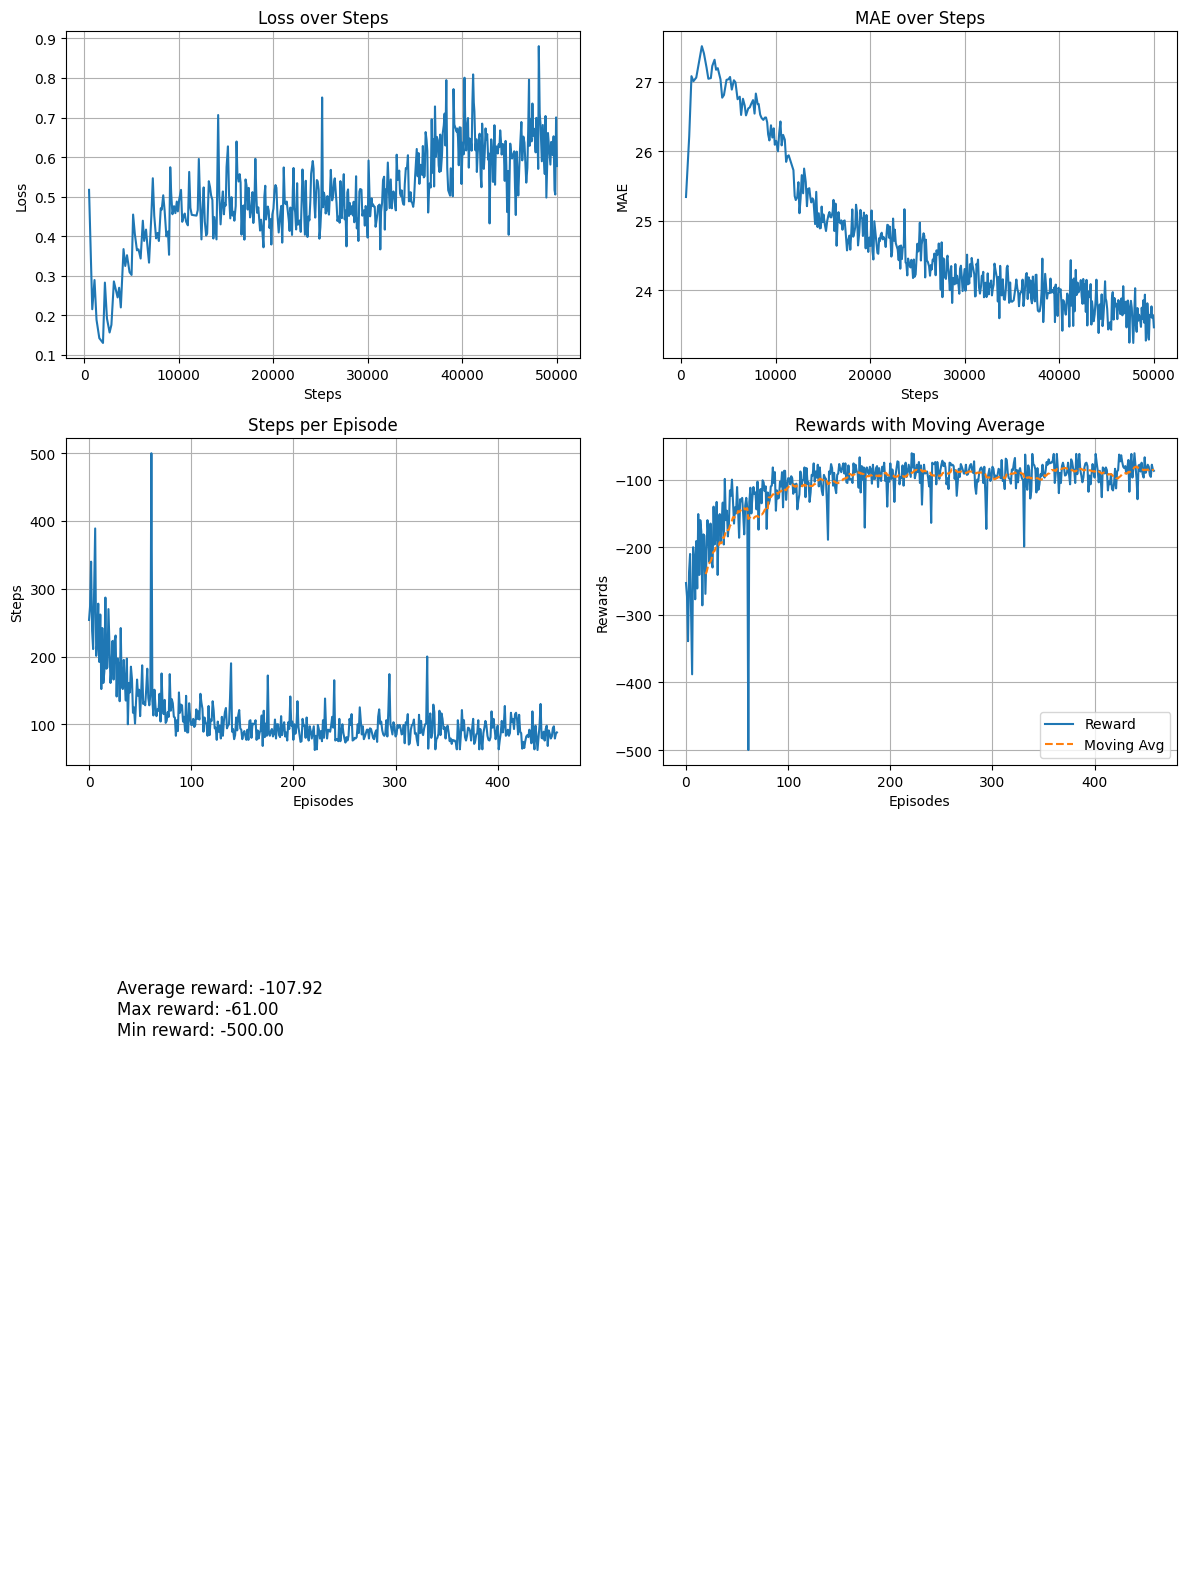

In [103]:
visualizar_log(log_filename)